In [26]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Julia/tut2`


## Dynamics

In [27]:
using LinearAlgebra
using ForwardDiff: jacobian
using Plots

function newton_ls(f,x0;ε=1e-8)
    x1 = x0

    for n=1:100
        # Function evaluation and gradient
        f0 = f(x0)
        nf0 = norm(f0)
        G = jacobian(f,x0)

        # Update calculation (x̂ = x0 - x1)
        x̂1 = G\f0

        # Newton update with line search
        x1 = x0 - x̂1
        norm(f(x1))>nf0 ? x1 = linesearch(f,x0,nf0,-x̂1) : nothing
        norm(x1-x0)<ε ? (return x1, n) : x0 = x1
    end

    return x1, -1
end

function linesearch(f,x0,nf0,d)
    α = 1
    x1 = x0 + 1/(2^α)*d

    for n=1:10
        norm(f(x1)) < nf0 ? (return x1) : x1 = x0 + 1/(2^α)*d
        α += 1
    end

    return x1
end;

### 1.1

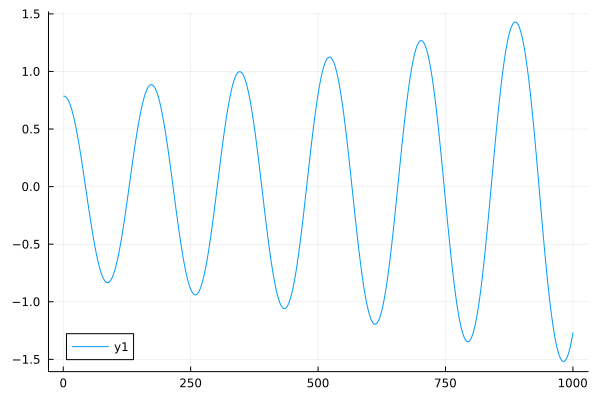

In [28]:
m = 1
l = 1
g = 9.81

function dynamics(θ,ddθ)
    1/3*m*l^2*ddθ+l/2*m*g*sin(θ)
end

θ = pi/4
dθ = 0
ddθ = 0
dt = 0.01

n = 1000
θstore = zeros(n)

for i=1:n
    θstore[i] = θ
    ddθnew = newton_ls(x->[dynamics(θ,x[1])],[ddθ])[1][1]
    dθnew = dθ + ddθnew*dt
    θnew = θ + dθ*dt
    
    θ = θnew
    dθ = dθnew
    ddθ = ddθnew
end

plot(θstore)

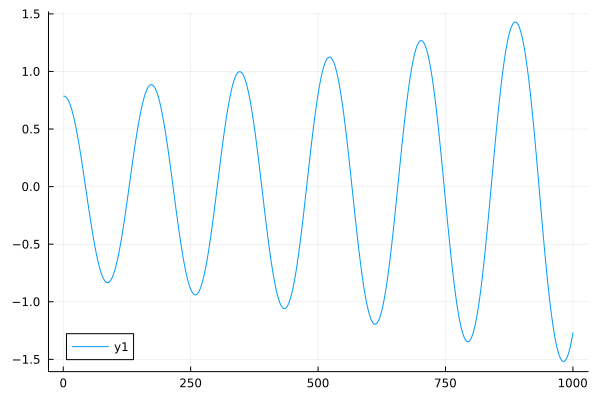

In [29]:
# in maximal coordinates
m = 1
l = 1
g = 9.81

function dynamics(x,dx,ddx,θ,dθ,ddθ,λ)
    [
        m*ddx
        1/12*m*l^2*ddθ
    ] - 
    [
        0
        -g*m
        0
    ] - 
    jacobian(var->constraints(x,dx,var[1:2],θ,dθ,var[3]),[ddx;ddθ])'*λ
end

function constraints(x,dx,ddx,θ,dθ,ddθ)
    # x-l/2*sin(θ)
    # y+l/2*cos(θ)

    # dx - l/2*cos(θ)*dθ
    # dy - l/2*sin(θ)*dθ

    [
        ddx[1] + l/2*sin(θ)*dθ - l/2*cos(θ)*ddθ
        ddx[2] - l/2*cos(θ)*dθ - l/2*sin(θ)*ddθ
    ]
end

function system(x,dx,ddx,θ,dθ,ddθ,λ)
    [
        dynamics(x,dx,ddx,θ,dθ,ddθ,λ)
        constraints(x,dx,ddx,θ,dθ,ddθ)
    ]
end

θ = pi/4
dθ = 0.0
ddθ = 0.0
x = [l/2*sin(θ);-l/2*cos(θ)]
dx = [0.0;0.0]
ddx = [0.0;0.0]
λ = [0.0;0.0]
dt = 0.01

n = 1000
θstore = zeros(n)

for i=1:n
    θstore[i] = θ
    sol = newton_ls(var->system(x,dx,var[1:2],θ,dθ,var[3],var[4:5]),[ddx;ddθ;λ])[1]
    ddxnew, ddθnew, λnew = sol[1:2], sol[3], sol[4:5]
    dxnew = dx + ddxnew*dt
    xnew = x + dx*dt
    dθnew = dθ + ddθnew*dt
    θnew = θ + dθ*dt
    
    x = xnew
    dx = dxnew
    ddx = ddxnew
    θ = θnew
    dθ = dθnew
    ddθ = ddθnew
    λ = λnew
end

plot(θstore)

### 1.2

In [30]:
m = 1
g = 9.81
ez = [0;0;1]

function dynamics(a)
    m*a + m*g*ez
end

newton_ls(dynamics,zeros(3))

([0.0, 0.0, -9.81], 2)

In [31]:
function dynamics(a,λ)
    m*a + m*g*ez - λ
end

function constraint(a)
    a
end

newton_ls(x->[dynamics(x[1:3],x[4:6]);constraint(x[1:3])], zeros(6))

([0.0, 0.0, 0.0, 0.0, 0.0, 9.81], 2)